>>> # decision variables should be 2*(N+1)+N = 92
>>> # equality constraints should be 2*(N+1) = 62
>>> max |g(init_guess)| = 0.9810000000000001
>>> obj at u=0 guess: 150000
>>> obj at u[0]=0.1   : 150000
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      212
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      120

Total number of variables............................:       92
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:       62
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality

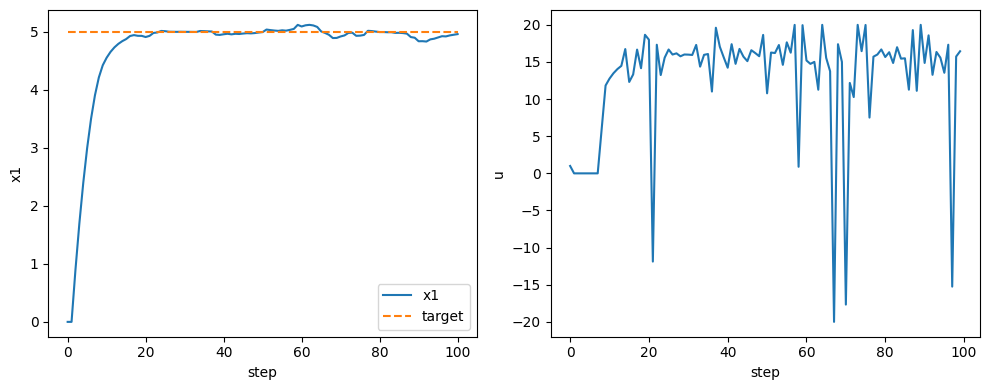

In [23]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

# ---- system/model parameters ----
dt = 0.1               # time step
g  = 9.81              # gravity
k  = 1.0               # control gain
eps = 0.1              # epsilon to avoid division by zero

# ---- CasADi symbols ----
X  = ca.SX.sym('X', 2)   # state vector [x1; x2]
u  = ca.SX.sym('u')      # scalar control
x1, x2 = X[0], X[1]

# continuous-time dynamics
xdot1 = x2
xdot2 = -g + k*u**2/( (x1+eps)**2 )

# discrete-time Euler step
X_next = X + dt * ca.vertcat(xdot1, xdot2)

# wrap as CasADi function
f = ca.Function('f', [X, u], [X_next], ['X','u'], ['X_next'])

# ---- user-adjustable parameters ------------------------------------
u_max = 20.0          # <- allow the input range you really need
N     = 30            # horizon length (≈ 6 s)
Q1    = 200.0         # position weight
Q2    =  30.0          # velocity weight
R     =  0.01         # control effort
# --------------------------------------------------------------------

x1_target = 5.0     # desired x1

# decision variables over the horizon
U = ca.SX.sym('U', N)
Xh = ca.SX.sym('Xh', 2, N+1)   # 2 rows, N+1 columns

# build objective and constraints
obj = 0

# dynamics constraints and cost
obj = 0
g_constr = []

# initial condition
g_constr.append( Xh[:,0] - X )

for k_idx in range(N):
    # 1) dynamics constraint
    Xpred = f( Xh[:,k_idx], U[k_idx] )
    g_constr.append( Xh[:,k_idx+1] - Xpred )

    # 2) stage cost
    obj += Q1*(Xh[0,k_idx] - x1_target)**2 \
         + Q2*(Xh[1,k_idx])**2 \
         + R*U[k_idx]**2

# stack constraints
g_v = ca.vertcat(*g_constr)

nlp = { 'f': obj,
        'x': ca.vertcat(ca.reshape(Xh,-1,1), U),
        'g': g_v,
        'p': X }

opts = {
  'ipopt.print_level': 5,
  'print_time':    1,
  'ipopt.max_iter': 50
}
solver = ca.nlpsol('solver','ipopt', nlp, opts)

# how many variables?
n_vars = ca.vertcat(ca.reshape(Xh,-1,1), U).size()[0]
print(">>> # decision variables should be 2*(N+1)+N =", n_vars)

# how many scalar constraints?
n_cons = g_v.size()[0]
print(">>> # equality constraints should be 2*(N+1) =", n_cons)

# ---- simulation ----
T = 100
x_current = np.array([0.0, 0.0])  # initial [x1, x2]
x_hist = [x_current.copy()]
u_hist = []

eval_g = ca.Function('eval_g', [ca.vertcat(ca.reshape(Xh,-1,1),U), X],
                             [g_v])

# build the “init_guess” exactly as you do in the loop
x0_guess = np.tile(x_current.reshape(-1,1), (1, N+1)).flatten()
u0_guess = np.zeros(N)
init_guess = np.concatenate([x0_guess, u0_guess])

resid = eval_g(init_guess, x_current).full().flatten()
print(">>> max |g(init_guess)| =", np.max(np.abs(resid)))
# This MUST be zero (or near floating-point zero), otherwise
# your constraints are not hooking up properly.

eval_obj = ca.Function('eval_obj', [ca.vertcat(ca.reshape(Xh,-1,1),U), X],
                               [obj])
print(">>> obj at u=0 guess:", eval_obj(init_guess, x_current))
# nudge just the first control to 0.1 and see if cost goes down
perturbed = init_guess.copy()
perturbed[(N+1)*2] = 0.1    # index of U[0]
print(">>> obj at u[0]=0.1   :", eval_obj(perturbed, x_current))

for t in range(T):
    # initial guess for [Xh; U]
    x0_guess = np.tile(x_current.reshape(-1,1), (1, N+1)).flatten()
    u0_guess = np.ones(N)
    init_guess = np.concatenate([x0_guess, u0_guess])

    # bounds: no bounds on states, but |u|<=1
    lbw = np.concatenate([[-ca.inf]*((N+1)*2),  [-u_max]*N])
    ubw = np.concatenate([[ ca.inf]*((N+1)*2),  [ u_max]*N])

    # all constraints are equalities g=0
    lbg = np.zeros(g_v.size()[0])
    ubg = np.zeros(g_v.size()[0])

    # solve
    sol = solver(x0=init_guess,
                 lbx=lbw, ubx=ubw,
                 lbg=lbg, ubg=ubg,
                 p=x_current)

    w_opt = sol['x'].full().flatten()
    u_opt = w_opt[(N+1)*2]   # first control is at index 2*(N+1)

    # apply control and step dynamics
    x_current = f(x_current, u_opt).full().flatten()
    x_hist.append(x_current.copy())
    u_hist.append(u_opt)

# ---- plotting ----
x_hist = np.array(x_hist)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(x_hist[:,0], label='x1')
plt.plot([x1_target]*len(x_hist),'--',label='target')
plt.xlabel('step'); plt.ylabel('x1'); plt.legend()

plt.subplot(1,2,2)
plt.plot(u_hist)
plt.xlabel('step'); plt.ylabel('u')

plt.tight_layout()
plt.show()